In [29]:
#from libs.prefect_helpers import *
from libs.data_manipulation import *
from libs.feature_generation import *
from libs.dim_reduction import *
from libs.football_plots import *
from libs.clustering import *
from libs.convex_hull import *

import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

from mplsoccer import *
import pandas as pd
import numpy as np
import os
# Click player into the pitch and take those player and apply Ripleys K to them. And then maybe PCA

from shapely.geometry import Point
from mplsoccer import Pitch
import alphashape


In [2]:

# Step 6: Extract match data from tracking data
data = compile_team_tracking_data("data/H_EURO2020", "DEN")
print(data.head())
one_match = extract_one_match(data, 1)

   frame_team  Time [s]_team half_team  home_1_x  home_1_y  home_3_x  \
0           0           0.00        1H     52.49     -0.08     19.96   
1           1           0.04        1H     52.51     -0.06     19.95   
2           2           0.08        1H     52.53     -0.05     19.95   
3           3           0.12        1H     52.51     -0.06     19.94   
4           4           0.16        1H     52.51     -0.05     19.94   

   home_3_y  home_4_x  home_4_y  home_5_x  ...  away_19_y  away_22_x  \
0      0.13     21.84     10.54     18.66  ...        NaN      -0.41   
1      0.14     21.87     10.56     18.68  ...        NaN      -0.40   
2      0.15     21.89     10.57     18.70  ...        NaN      -0.34   
3      0.16     21.90     10.58     18.73  ...        NaN      -0.29   
4      0.17     21.92     10.59     18.76  ...        NaN      -0.23   

   away_22_y  away_23_x  away_23_y  away_26_x  away_26_y  ball_x  ball_y  \
0      28.75      -0.43      33.28        NaN        NaN  

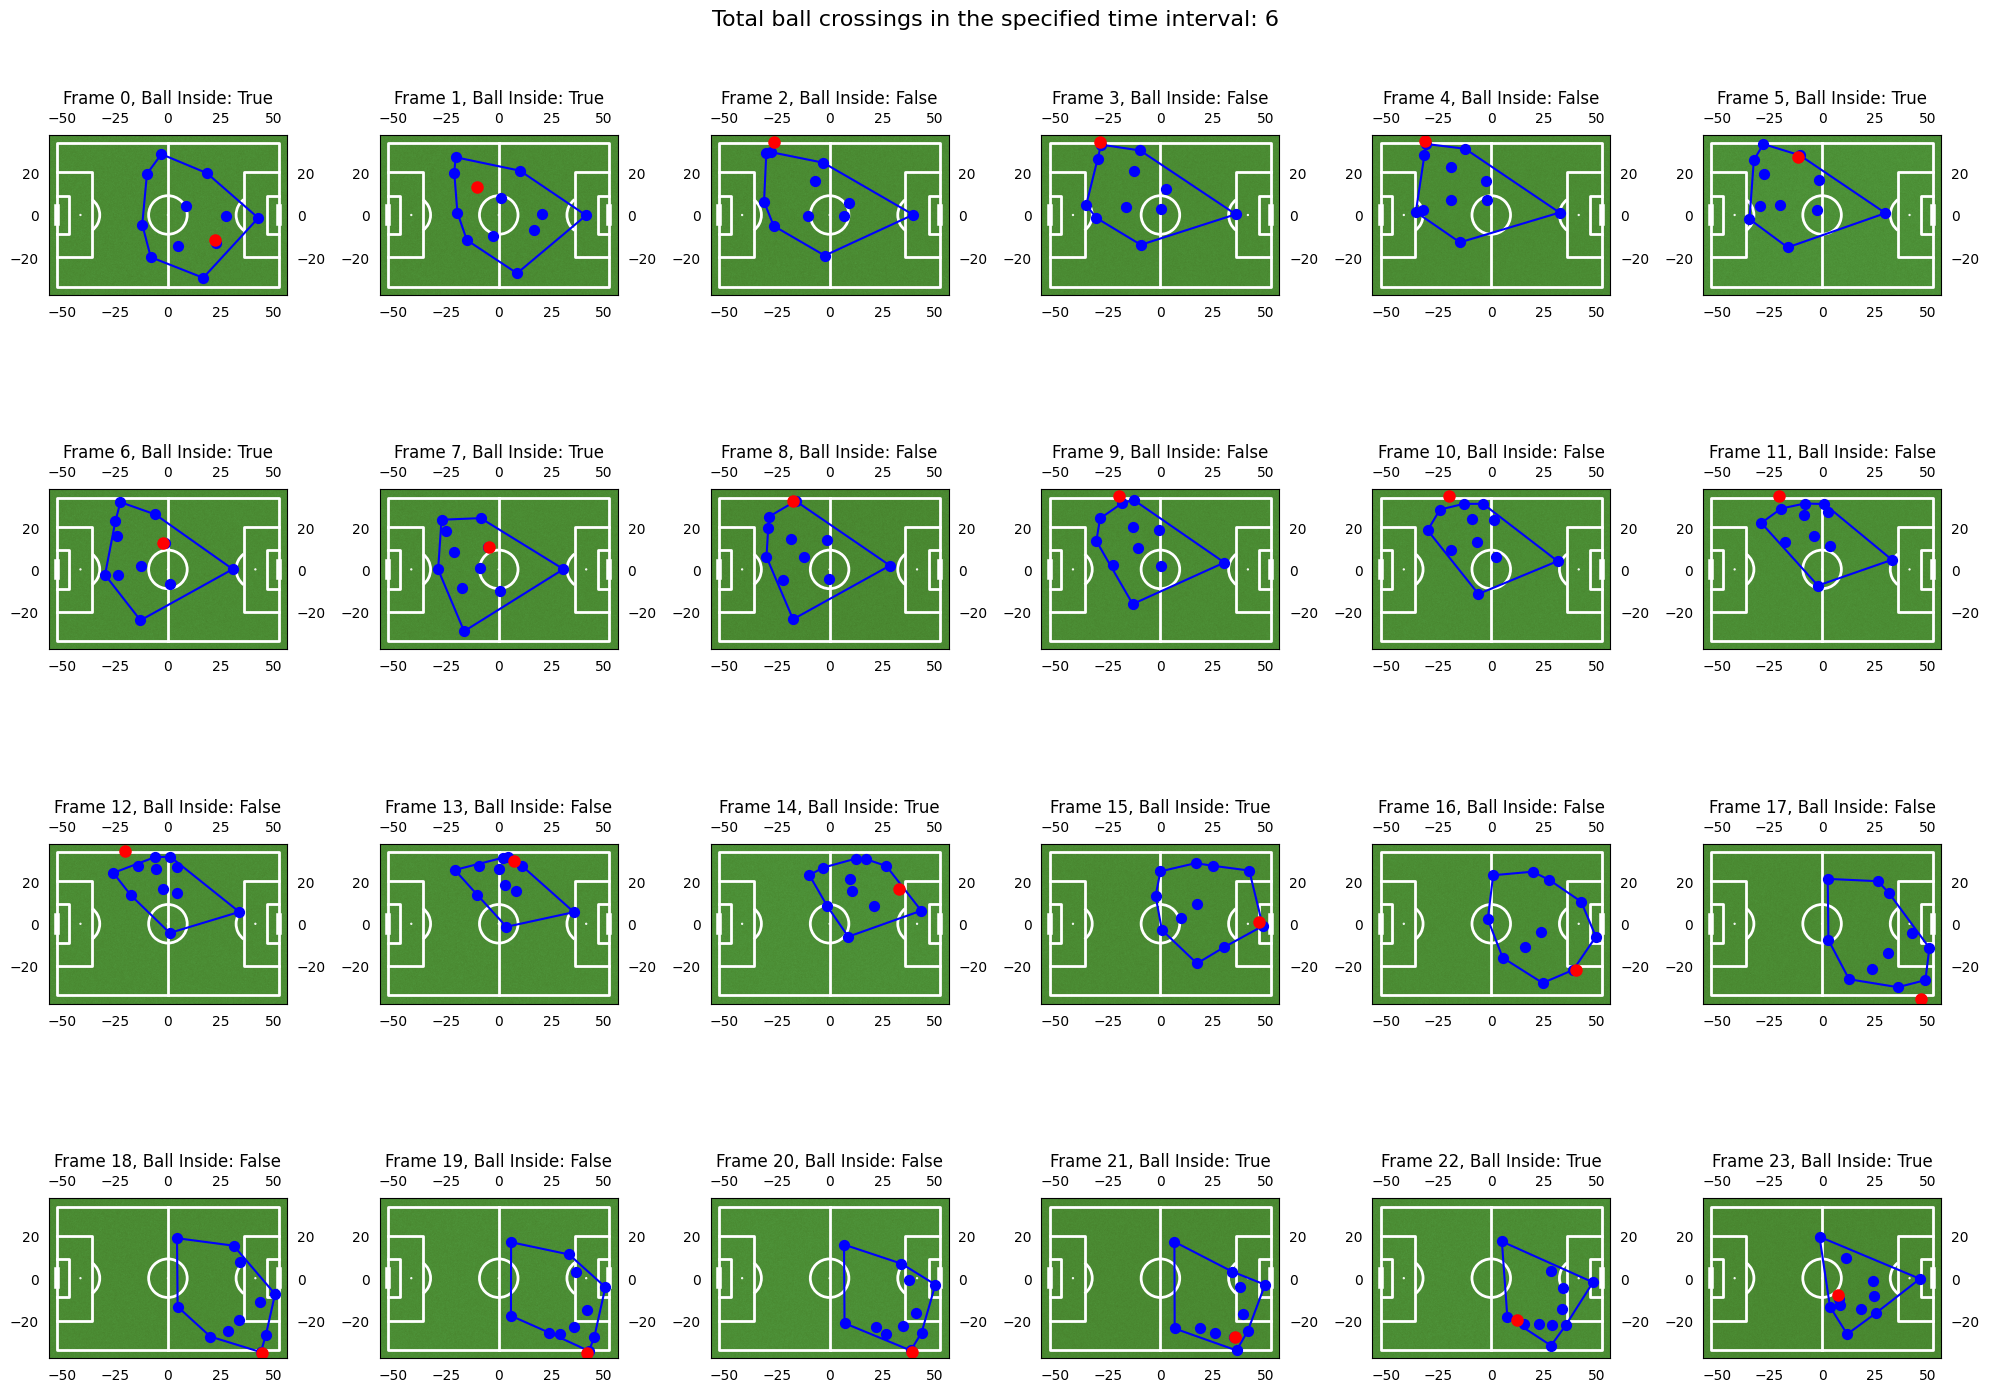

In [27]:
# Make the implementation above as a function

def plot_alpha_shape_crossings(data, match_id, start_time_index, interval_seconds, sampling_interval):
    # Extract the data for the specified match
    one_match = extract_one_match(data, match_id)

    # Set the start time index and the length of the time interval (in seconds)
    frame_rate = 24  # Assume 24 frames per second

    # Calculate the number of frames in the interval
    interval_frames = interval_seconds * frame_rate

    # Track ball crossing events
    crossing_count = 0
    was_inside = None  # Track if the ball was inside or outside the polygon in the previous frame

    # Create a pitch for plotting
    fig, axes = plt.subplots(4, 6, figsize=(20, 15))  # Create a grid for 10 situations
    axes = axes.flatten()  # Flatten the grid to easily access each subplot

    # Loop over the frames in the specified interval with the sampling interval
    for idx, frame_idx in enumerate(range(start_time_index, start_time_index + interval_frames, sampling_interval)):
        if idx >= len(axes):  # Ensure we don't exceed the available subplot axes
            break

        ax = axes[idx]
        football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
        football_pitch.draw(ax=ax)

        # Get the player positions for this frame
        frame_data = one_match.iloc[frame_idx]
        home_positions = frame_data.filter(regex="^home").dropna().values.reshape(-1, 2).astype(float)

        # Generate the alpha shape polygon for the current frame
        if len(home_positions) >= 3:  # Ensure there are enough points to form an alpha shape
            alpha_shape_polygon = alphashape.alphashape(home_positions, alpha=0.005)

            # Plot the polygon edges if the polygon is valid
            if alpha_shape_polygon and not alpha_shape_polygon.is_empty and alpha_shape_polygon.exterior:
                x, y = alpha_shape_polygon.exterior.xy
                ax.plot(x, y, color='blue', label="Alpha Shape")

        # Plot the player positions
        ax.scatter(home_positions[:, 0], home_positions[:, 1], color='blue', s=50, label="Players")

        # Get the ball's position
        ball_x = frame_data['ball_x']
        ball_y = frame_data['ball_y']
        ball_position = Point(ball_x, ball_y)

        # Plot the ball's position
        ax.plot(ball_x, ball_y, 'o', color='red', markersize=8, label="Ball")

        # Check if the ball is inside the alpha shape polygon
        is_inside = alpha_shape_polygon.contains(ball_position) if alpha_shape_polygon else False

        # Check for crossing
        if was_inside is not None and was_inside != is_inside:
            crossing_count += 1

        # Update the previous state
        was_inside = is_inside

        # Set title for each subplot
        ax.set_title(f"Frame { idx}, Ball Inside: {is_inside}")

    # Display the total crossing count
    plt.suptitle(f"Total ball crossings in the specified time interval: {crossing_count}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Test the function
plot_alpha_shape_crossings(data, 1, 1000, 100, 76)

